# Bitcoin Price Forecasting

## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote
from datetime import timedelta, datetime

## Import necessary API
import sys
sys.path.append('../../../../')
from api.v2.util.data_load import data_load
from api.v2.model.SparseTSF import SparseTSF
from api.v2.util.set_minmax import set_minmax_value
from api.v2.Preprocessing.MinMaxScaler import MinMaxScaler
from api.v2.util.compare_graph import compare_graph
from types import SimpleNamespace

## Import libraries for the model
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score

## Set path for saving model training results
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Base Parameter Setting
* Set parameters based on the information identified during EDA (Exploratory Data Analysis).

In [ ]:
# Set Bitcoin Data Parameter

# Set MachBase Neo URL address
URL = 'http://127.0.0.1:5654'
# Set Tag Table Name
table = 'Bitcoin'
# Select Tag Name -> Can Check Tag Names Using command 'show_column(URL, table)'
tags = ['KRW-BTC']
# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)
# Set Tag Name
name = quote(tags_, safe=":/")
# Set TimeFormat - > 'default' or '2006-01-02 15:04:05.000000'(Divided down to the nanosecond)
timeformat = '2006-01-02 15:04:05.000000'
# Set resample Option -> D(day), H(hour), T(minute), S(second)
resample_freq = '1T'
# Set Start time
start_time = '2024-11-24 11:40:00'
# Set End time 
end_time = '2024-12-23 01:16:00'
# Set TimeFormat - > 'default' or quote('2006-01-02 15:04:05.000000')(Divided down to the nanosecond)
timeformat = quote('2006-01-02 15:04:05.000000')

## Model Configuration
* Using SparseTSF model.

In [3]:
# Parameter configuration
configs = SimpleNamespace(
    enc_in=1,  # Number of input features (e.g., number of features in time-series data)
    seq_len=10,  # Input sequence length (e.g., number of timesteps)
    pred_len=1,  # Prediction length (e.g., number of timesteps to predict)
    period_len=1,  # Period length (sub-sequence length)
    d_model=128,  # Model dimension (hidden state size)
    model_type='mlp',  # Type of model: 'linear' or 'mlp'
    use_revin=False,  # Whether to use RevIN preprocessing
)


In [4]:
# Learning rate
lr = 0.001

# Model configuration
model = SparseTSF(configs).to(device)

# Configure loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Check the model architecture
print(model)

SparseTSF(
  (conv1d): Conv1d(1, 1, kernel_size=(1,), stride=(1,), bias=False)
  (mlp): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


## Dataset & Loader Setup
- This function creates sliding windows of historical data for input and corresponding future values for forecast based on the specified window size and forecast size.

In [5]:
# Sliding Window Dataset Configuration
def time_slide_df(df, window_size, forecast_size):
    df_ = df.copy()
    data_list = []
    dap_list = []
    for idx in range(0, df_.shape[0]-window_size-forecast_size+1):
        x = df_.iloc[idx:idx+window_size].values.reshape(window_size, df.shape[1])
        y = df_.iloc[idx+window_size:idx+window_size+forecast_size].values
        data_list.append(x)
        dap_list.append(y)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

## Model Training

In [ ]:
# Model training function
def train(epochs, start_time_train, end_time_train, unit, Fetch_size, URL, table, name, timeformat, resample_freq, scaler, Min, Max, window_size, forecast_size, batch_size):
    
    # Initialize loss
    train_loss = []
    
    # Initialize best Loss value
    best_Loss= np.inf
    
    # Start model training
    for epoch in epochs:
        
        # Set the model to training mode
        model.train()
        
        # Initialize loss and total step
        running_loss = 0.0
        total_step = 0
        
        # Set initial Time
        args = {unit: Fetch_size}
        start_time = start_time_train
        end_time = str(datetime.strptime(start_time_train, "%Y-%m-%d %H:%M:%S") + timedelta(**args))
        end_time_train_ = str(datetime.strptime(end_time_train, "%Y-%m-%d %H:%M:%S") + timedelta(seconds=1))
        
        # Set flag
        flag = False

        while end_time < end_time_train_:
            
            # Load batch data
            data = data_load(URL, table, name, start_time, end_time, timeformat, resample_freq)
            
            # Apply MinMaxscaler
            data_scaled = scaler.fit_transform(data, Min, Max)
            
            # Set up the DataFrame
            data = pd.DataFrame(data_scaled)
            
            # Drop NaN values
            data = data.dropna()

            # Set up dataset & Loader
            train_x, train_y = time_slide_df(data, window_size, forecast_size)
            
            train_ds = Data(train_x, train_y)

            train_dataloader = DataLoader(train_ds, batch_size, shuffle=False)

            # Print if the loaded data is empty
            if len(train_x) != 0:
                
                for batch_idx, (data, target) in enumerate(train_dataloader):
                    
                    # Check total batch count
                    total_step += 1
                    
                    data = data.to(device).float()
                    target = target.to(device).float()
                    
                    optimizer.zero_grad()
                
                    # Input to the model
                    outputs = model(data)
                    
                    # Calculate loss
                    loss = criterion(outputs, target)
                    loss.backward()
                    optimizer.step()
                    
                    running_loss += loss.item()
                    
            # Update start_time and end_time for next batch
            start_time = end_time
            end_time = str(datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S") + timedelta(**args))
            
            # Select the remaining portions at the end
            if end_time >= end_time_train and not flag:
                
                end_time = end_time_train
                flag = True   

        # Print training loss
        train_loss.append(running_loss / total_step)
        print(f'\ntrain loss: {np.mean(train_loss)}')    
        
        # Save the model if it has the best loss
        if best_Loss > np.mean(train_loss):
            best_Loss = np.mean(train_loss)
            torch.save(model, f'./result/Bitcoin_Buffered_Fetch.pt')
            print('Model saved')
        epochs.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")
     
    return model

In [ ]:
# Set number of epochs
epochs = trange(100, desc='training')
# Unit of time ('days', 'hours', 'minutes', 'seconds')
unit = 'days'
Fetch_size = 10
# Window size: How many past data points will be used
# Forecast: How many future data points to forcast
window_size = 10
forecast_size= 1
# Set Batch Size
batch_size = 32
# Set Train Time
start_time_train = '2024-11-24 20:00:00'
end_time_train = '2024-12-22 00:00:00'
# Set up scalers
scaler = MinMaxScaler()
# Set Min, Max value
Min, Max = set_minmax_value(URL, table, name, start_time_train, end_time_train)

#################################################################Training#############################################################################################
train(epochs, start_time_train, end_time_train, unit, Fetch_size, URL, table, name, timeformat, resample_freq, scaler, Min, Max, window_size, forecast_size, batch_size)

training:   0%|          | 0/100 [00:00<?, ?it/s]


train loss: 9.339220362721659e-05
Model saved

train loss: 5.1836572155858786e-05
Model saved

train loss: 3.7340506638153195e-05
Model saved

train loss: 2.9978290491324656e-05
Model saved

train loss: 2.5442017560526795e-05
Model saved

train loss: 2.2336524765807794e-05
Model saved

train loss: 2.004606633918974e-05
Model saved

train loss: 1.8291025546034545e-05
Model saved

train loss: 1.687479681819368e-05
Model saved

train loss: 1.574224054127654e-05
Model saved

train loss: 1.4808336235719615e-05
Model saved

train loss: 1.40268405905115e-05
Model saved

train loss: 1.3362306236232846e-05
Model saved

train loss: 1.2777279976041044e-05
Model saved

train loss: 1.2270716268476688e-05
Model saved

train loss: 1.182063143621446e-05
Model saved

train loss: 1.1430446458105017e-05
Model saved

train loss: 1.1067077103412594e-05
Model saved

train loss: 1.075612869425935e-05
Model saved

train loss: 1.0457954476381824e-05
Model saved

train loss: 1.0195708983630039e-05
Model saved


SparseTSF(
  (conv1d): Conv1d(1, 1, kernel_size=(1,), stride=(1,), bias=False)
  (mlp): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

## Model Test

In [ ]:
def test(model, start_time_test, end_time_test, unit, Fetch_size, URL, table, name, timeformat, resample_freq, scaler, Min, Max, window_size, forecast_size, batch_size):
    
    with torch.no_grad():
                
        model.eval()
        
        # Initial settings 
        output_test = []
        output_target = []
        
        # Set initial Time
        args = {unit: Fetch_size}
        start_time = start_time_test
        end_time = str(datetime.strptime(start_time_test, "%Y-%m-%d %H:%M:%S") + timedelta(**args))
        end_time_test_ = str(datetime.strptime(end_time_test, "%Y-%m-%d %H:%M:%S") + timedelta(seconds=1))
        
        # Set flag
        flag = False
        
        while end_time < end_time_test_:
            
            # Load batch data
            data = data_load(URL, table, name, start_time, end_time, timeformat, resample_freq)
            
            # Apply MinMaxscaler
            data_scaled = scaler.fit_transform(data, Min, Max)
            
            # Set up the DataFrame
            data = pd.DataFrame(data_scaled)
            
            # Drop NaN values
            data = data.dropna()

            # Set up dataset & Loader
            test_x, test_y = time_slide_df(data, window_size, forecast_size)
            
            test_ds = Data(test_x, test_y)

            test_dataloader = DataLoader(test_ds, batch_size, shuffle=False)
            
            # Print if the loaded data is empty
            if len(test_x) != 0:
                
                for batch_idx, (data, target) in enumerate(test_dataloader):
                    
                    data = data.to(device).float()
                    target = target.to(device).float()
                
                    # Input to the model
                    outputs = model(data)
                    
                    output_test.append(outputs)
                    output_target.append(target)
        
            # Update start_time and end_time for next batch
            start_time = end_time
            end_time = str(datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S") + timedelta(**args))
            
            # Select the remaining portions at the end
            if end_time >= end_time_test and not flag:
                
                end_time = end_time_test
                flag = True   
 
        # Combine tensors into one
        combined_tensor_target = torch.cat(output_target, dim=0)
        combined_tensor_pred = torch.cat(output_test, dim=0)

        # Use only the last value of the window
        last_values_target = combined_tensor_target[:,:1].cpu()
        last_values_pred = combined_tensor_pred[:,:1].cpu()

        # Inverse transform using MinMaxScaler 
        real_values = scaler.inverse_transform(last_values_target.numpy().reshape(-1, 1))
        pred_values = scaler.inverse_transform(last_values_pred.numpy().reshape(-1, 1))
        
    return real_values, pred_values  

In [ ]:
# Load the best model
model_ = torch.load(f'./result/Bitcoin_Buffered_Fetch.pt')

# Unit of time ('days', 'hours', 'minutes', 'seconds')
unit = 'days'
Fetch_size = 5
# Set Test Tiem
start_time_test = '2024-12-22 00:00:00'
end_time_test = '2024-12-31 00:00:00'

##################################################################################Test############################################################################################################
real_values, pred_values = test(model_, start_time_test, end_time_test, unit, Fetch_size, URL, table, name, timeformat, resample_freq, scaler, Min, Max, window_size, forecast_size, batch_size)

## Model Performance Evaluation

In [ ]:
# Calculate MSE
mse = mean_squared_error(real_values, pred_values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(real_values, pred_values)
print("R² Score:", r2)

Mean Squared Error: 4194340049.7881064
R² Score: 0.9970309883532227


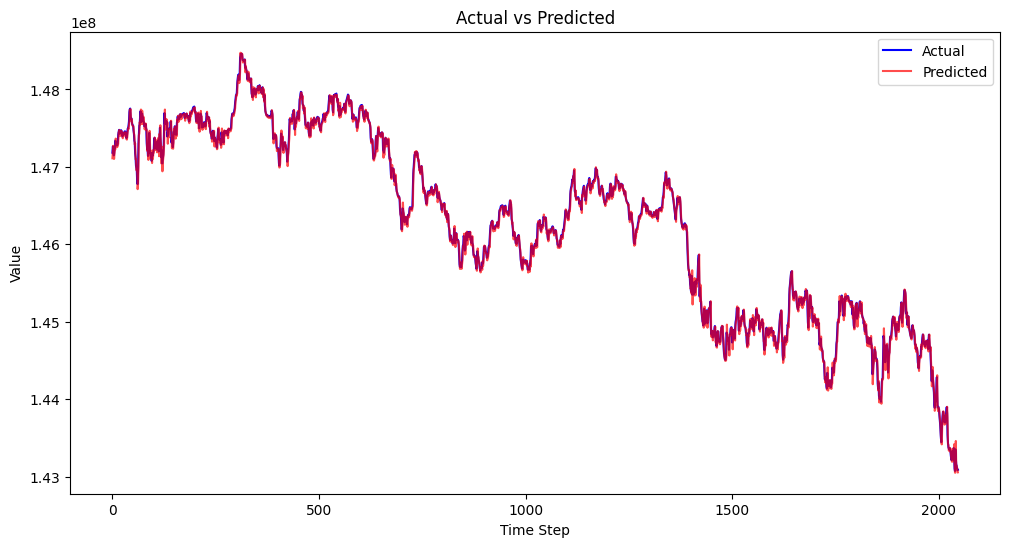

In [ ]:
# Compare the test results: Actual values vs Predicted values

# Plot width
x_size=12
# Plot height
y_size=6
# Print Compare_graph
compare_graph(real_values, pred_values, x_size, y_size)